<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Calling_Agents_5_(Reducers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reducer

A practical challenge when working  with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

we have a few ways to address this.

In [ ]:
pip install -q langchain langchain_openai langchain_community langgraph langchain-core

In [2]:
import os
os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"

In [41]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"Do you want to know more about LLM?", name = "Agent")]
messages.append(HumanMessage(f"Yes, I know about LLM.But what are the real life use cases of LLM?", name= "User"))

for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Agent

Do you want to know more about LLM?
================================ Human Message =================================
Name: User

Yes, I know about LLM.But what are the real life use cases of LLM?


In [42]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)
llm.invoke(messages)

AIMessage(content="Large Language Models (LLMs) have a wide range of real-life use cases across various industries. Here are some notable examples:\n\n1. **Customer Support**: LLMs can power chatbots and virtual assistants to handle customer inquiries, provide support, and resolve issues, improving response times and customer satisfaction.\n\n2. **Content Creation**: They can assist in generating articles, blog posts, marketing copy, and social media content, helping writers brainstorm ideas or even produce complete drafts.\n\n3. **Language Translation**: LLMs can provide real-time translation services, making communication easier across different languages and cultures.\n\n4. **Personal Assistants**: Virtual assistants like Siri, Alexa, and Google Assistant use LLMs to understand and respond to user queries, manage schedules, and control smart home devices.\n\n5. **Education and Tutoring**: LLMs can serve as personalized tutors, providing explanations, answering questions, and generat

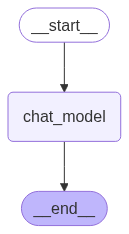

In [43]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

#Node
def chat_model_node(state:MessagesState)-> MessagesState:
  return {"messages":llm.invoke(state["messages"])}

#Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))


In [44]:
output = graph.invoke({'messages':messages})
for m in output['messages']:
  m.pretty_print()

================================== Ai Message ==================================
Name: Agent

Do you want to know more about LLM?
================================ Human Message =================================
Name: User

Yes, I know about LLM.But what are the real life use cases of LLM?
================================== Ai Message ==================================

Large Language Models (LLMs) have a wide range of real-life use cases across various industries. Here are some notable examples:

1. **Customer Support**: LLMs can power chatbots and virtual assistants to handle customer inquiries, provide support, and resolve issues in real-time, improving response times and customer satisfaction.

2. **Content Creation**: They can assist in generating articles, blog posts, marketing copy, and social media content, helping writers brainstorm ideas or even produce complete drafts.

3. **Language Translation**: LLMs can provide high-quality translations between languages, making communica

1. Message filtering

When we have long-running conversations and have X number of messages, and we decide to keep onlt the last 5-10% messages to maintain the context and reduce the number of tokens.

eg: I have 100 messages and we want to keep the last 10 messages to maintain the context

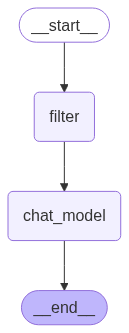

In [45]:
from langchain_core.messages import RemoveMessage


#Nodes
def filter_messages(state:MessagesState) ->MessagesState:
  #Delete all but the 2 most recent messages:
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"messages":delete_messages}

def chat_model_node(state:MessagesState)->MessagesState:
  return {"messages": [llm.invoke(state["messages"])]}

#Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()


#view
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
#Message list with a preamble
message = [AIMessage("Hi.", name = "Agent", id="1")]
messages.append(HumanMessage("Hi.", name = "User", id = "2"))
messages.append(AIMessage("Do you want to know more about LLM?", name="Agent", id = "3"))
messages.append(HumanMessage("Yes, I know about LLM.But what are the real life use cases of LLM?", name="User", id = "4"))

#Invoke
output = graph.invoke({"messages":messages})
for m in output['messages']:
  m.pretty_print()

================================== Ai Message ==================================
Name: Agent

Do you want to know more about LLM?
================================ Human Message =================================
Name: User

Yes, I know about LLM.But what are the real life use cases of LLM?
================================== Ai Message ==================================

Large Language Models (LLMs) have a wide range of real-life use cases across various industries. Here are some notable examples:

1. **Customer Support**: LLMs can power chatbots and virtual assistants to handle customer inquiries, provide support, and resolve issues, improving response times and customer satisfaction.

2. **Content Creation**: They can assist in generating articles, blog posts, marketing copy, and social media content, helping writers brainstorm ideas or even produce complete drafts.

3. **Language Translation**: LLMs can provide real-time translation services, making communication easier across differe

#Filtering Mesages

if you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

for example, just pass in a filtered list: llm.invoke(messages[-1:]) to the model

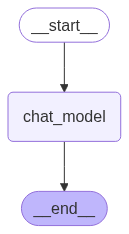

In [47]:
#node
def chat_model_node(state:MessagesState)->MessagesState:
  return {"messages": [llm.invoke(state["messages"][-1:])]}

#Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()


#view
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing lif of messages, append the above LLM response, and append a follow-up question.

In [48]:
#Messages
messages.append(output["messages"][-1])
messages.append(HumanMessage(f"Tell me more about LLM!", name="User"))


In [49]:
#Invoke, using message filtering

for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Agent

Do you want to know more about LLM?
================================ Human Message =================================
Name: User

Yes, I know about LLM.But what are the real life use cases of LLM?
================================ Human Message =================================
Name: User

Hi.
================================== Ai Message ==================================
Name: Agent

Do you want to know more about LLM?
================================ Human Message =================================
Name: User

Yes, I know about LLM.But what are the real life use cases of LLM?
================================== Ai Message ==================================

Large Language Models (LLMs) have a wide range of real-life use cases across various industries. Here are some notable examples:

1. **Customer Support**: LLMs can power chatbots and virtual assistants to handle customer inquiries, provide s

In [50]:
#Invoke, using message filtering
output = graph.invoke({"messages":messages})
for m in output['messages']:
  m.pretty_print()

================================== Ai Message ==================================
Name: Agent

Do you want to know more about LLM?
================================ Human Message =================================
Name: User

Yes, I know about LLM.But what are the real life use cases of LLM?
================================ Human Message =================================
Name: User

Hi.
================================== Ai Message ==================================
Name: Agent

Do you want to know more about LLM?
================================ Human Message =================================
Name: User

Yes, I know about LLM.But what are the real life use cases of LLM?
================================== Ai Message ==================================

Large Language Models (LLMs) have a wide range of real-life use cases across various industries. Here are some notable examples:

1. **Customer Support**: LLMs can power chatbots and virtual assistants to handle customer inquiries, provide s

The state has all of the messages.